In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

In [3]:
# #get rid of scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# import file
data_1 = pd.read_csv("data_exp_24005-v6/data_exp_24005-v6_task-t2w7.csv", sep = ",")
data_2 = pd.read_csv("data_exp_24005-v6/data_exp_24005-v6_task-lhx6.csv", sep = ",")


In [6]:
data_2.drop(['Unnamed: 37', 'Unnamed: 39'], axis = 1, inplace = True)


In [7]:
data = pd.concat([data_1, data_2])

In [8]:
data = data.replace('null', np.nan)
data  = data.replace('nan', np.nan)


In [9]:
data['start_time'] = round(data['start_time'].astype(float))

In [10]:
data.columns

Index(['Event Index', 'UTC Timestamp', 'UTC Date', 'Local Timestamp',
       'Local Timezone', 'Local Date', 'Experiment ID', 'Experiment Version',
       'Tree Node Key', 'Repeat Key', 'Schedule ID', 'Participant Public ID',
       'Participant Private ID', 'Participant Starting Group',
       'Participant Status', 'Participant Completion Code',
       'Participant External Session ID', 'Participant Device Type',
       'Participant Device', 'Participant OS', 'Participant Browser',
       'Participant Monitor Size', 'Participant Viewport Size', 'Checkpoint',
       'Task Name', 'Task Version', 'randomiser-cdvn', 'reaction time',
       'key pressed', 'price_displayed', 'environment', 'task', 'function id',
       'builtin rt', 'end_time', 'start_time', 'response', 'round_instance'],
      dtype='object')

In [11]:
data = data[['Participant Private ID', 'UTC Timestamp','key pressed', 'price_displayed', 'environment', 'task', 'function id',
       'builtin rt', 'end_time', 'start_time', 'response', 'round_instance']]


In [12]:
data.rename(columns={"Participant Private ID": "Subject"}, inplace = True)


In [13]:
data = data.sort_values(by = ['Subject', 'start_time'])

In [14]:
data['trial_label'] = data[['environment', 'round_instance']].apply(lambda x: ' '.join(x.astype(str)), axis=1)


In [15]:
fish = data[(data.task == "fishing_pos")|(data.task == "fishing_neg")]


In [16]:
fish = fish[fish['start_time'].notna()]

In [17]:
fish['start_time'] = fish['start_time'].astype(int)

In [18]:
fish.environment.unique()

array(['pre_mood', 'post_mood'], dtype=object)

In [19]:
fish["environment_binary"] = np.where(fish["environment"] == 'pre_mood', 0, 1)


In [20]:
d = fish.groupby(['Subject','environment_binary', 'round_instance'])['start_time'].diff().shift(-1).reset_index(name = 'latency')
d = d.set_index('index')


In [21]:
fish['latency'] = d['latency']
fish = fish.sort_index().sort_values(['Subject', 'start_time'])

In [22]:
fish.head()

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,environment_binary,latency
4,1886514.000,1598309451266.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,906.090,1598309451148.000,1598309450241,nan,1.000,pre_mood 1.0,0,1012.000
5,1886514.000,1598309451438.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,70.425,1598309451324.000,1598309451253,nan,1.000,pre_mood 1.0,0,175.000
6,1886514.000,1598309451563.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,30.795,1598309451459.000,1598309451428,nan,1.000,pre_mood 1.0,0,134.000
7,1886514.000,1598309451688.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,16.975,1598309451580.000,1598309451562,nan,1.000,pre_mood 1.0,0,121.000
8,1886514.000,1598309451830.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,32.335,1598309451715.000,1598309451683,nan,1.000,pre_mood 1.0,0,136.000


In [23]:
def mask_first(x):
    """
    get rid of the first spike by creating a mask of 0, 1, 1, 1, ...
    """
    result = np.ones_like(x)
    result[0] = 0
    return result

In [24]:
mask = fish.groupby(['Subject', 'environment'])['round_instance'].transform(mask_first).astype(bool)

# data_useful = data_useful.loc[mask]


In [25]:
fish = fish.loc[mask]

In [26]:
fish.head()
fish["mood"] = fish["task"].map({'fishing_pos': "pos", 'fishing_neg':'neg'})


In [27]:
# mood graph
mood_graph = fish[(fish.environment == "post_mood")]

In [28]:
g = mood_graph.groupby(["environment","mood","price_displayed"])['latency'].mean().reset_index()


In [29]:
g

,environment,mood,price_displayed,latency
0,post_mood,neg,0.100,191.130
1,post_mood,neg,0.400,180.673
2,post_mood,neg,5.100,208.848
3,post_mood,neg,6.000,148.331
4,post_mood,pos,0.100,154.316
5,post_mood,pos,0.400,162.223
6,post_mood,pos,5.100,162.724
7,post_mood,pos,6.000,170.926


In [30]:
price = [0.1, 0.4, 5.1, 6.0]
latency_p = g.latency[(g.mood == 'pos')]
latency_n = g.latency[(g.mood == 'neg')]

In [33]:
data.Subject.nunique()

10

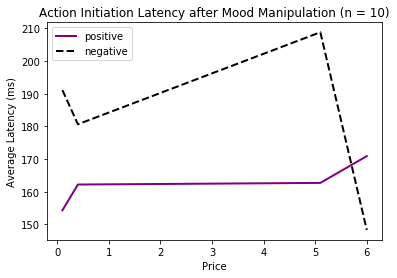

In [34]:
plt.plot( price, latency_p, marker='', color='purple', linewidth=2, label = "positive")
plt.plot( price, latency_n, marker='', color='black', linewidth=2, linestyle='dashed', label="negative")
plt.title("Action Initiation Latency after Mood Manipulation (n = 10)")
plt.xlabel("Price")
plt.ylabel("Average Latency (ms)")
plt.legend()
plt.savefig('price_latency_after_mood.png', transparent=True, dpi=300)


In [35]:
# response
rating = data[(data.task == "mood_rating_pos")|(data.task == "mood_rating_neg")]


In [36]:
rating = rating[rating["response"].notna()]
rating

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label
297,1886514.000,1598309499623.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,76.000,4.000,pre_mood 4.0
548,1886514.000,1598309549152.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,75.000,8.000,pre_mood 8.0
817,1886514.000,1598309595151.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,92.000,12.000,pre_mood 12.0
1083,1886514.000,1598309683037.000,nan,nan,post_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,97.000,4.000,post_mood 4.0
1340,1886514.000,1598309727716.000,nan,nan,post_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,95.000,8.000,post_mood 8.0
1606,1886514.000,1598309776964.000,nan,nan,post_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,91.000,12.000,post_mood 12.0
3294,1886517.000,1598309643250.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,93.000,4.000,pre_mood 4.0
3589,1886517.000,1598309690178.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,88.000,8.000,pre_mood 8.0
3878,1886517.000,1598309734598.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,83.000,12.000,pre_mood 12.0
4184,1886517.000,1598309811745.000,nan,nan,post_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,97.000,4.000,post_mood 4.0


In [37]:
rating["response"].describe()

count    60.000
mean     74.150
std      28.526
min       8.000
25%      50.000
50%      89.000
75%      94.000
max     100.000
Name: response, dtype: float64

In [38]:
rating = rating.sort_values(["Subject", "UTC Timestamp"])

In [39]:
rating["index"]=[1]*len(rating)


In [40]:
i = rating.groupby(["Subject", "environment"])["index"].cumsum().reset_index(name = "index")
rating = pd.merge(rating, i, left_on=rating.index, right_on = "level_0", how = "inner")
rating.head()

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,index_x,level_0,index_y
0,1886514.000,1598309499623.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,76.000,4.000,pre_mood 4.0,1,297,1
1,1886514.000,1598309549152.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,75.000,8.000,pre_mood 8.0,1,548,2
2,1886514.000,1598309595151.000,nan,nan,pre_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,92.000,12.000,pre_mood 12.0,1,817,3
3,1886514.000,1598309683037.000,nan,nan,post_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,97.000,4.000,post_mood 4.0,1,1083,1
4,1886514.000,1598309727716.000,nan,nan,post_mood,mood_rating_pos,mood_rating_pos,nan,nan,nan,95.000,8.000,post_mood 8.0,1,1340,2


In [41]:
rating.drop(["index_x", "level_0"], axis = 1, inplace = True)

In [42]:
rating["mood"] = rating["task"].map({"mood_rating_pos":"pos",
                                    "mood_rating_neg":"neg"})

In [43]:
rating["name"] = rating["Subject"].astype(int).astype(str) + " " + rating["mood"]


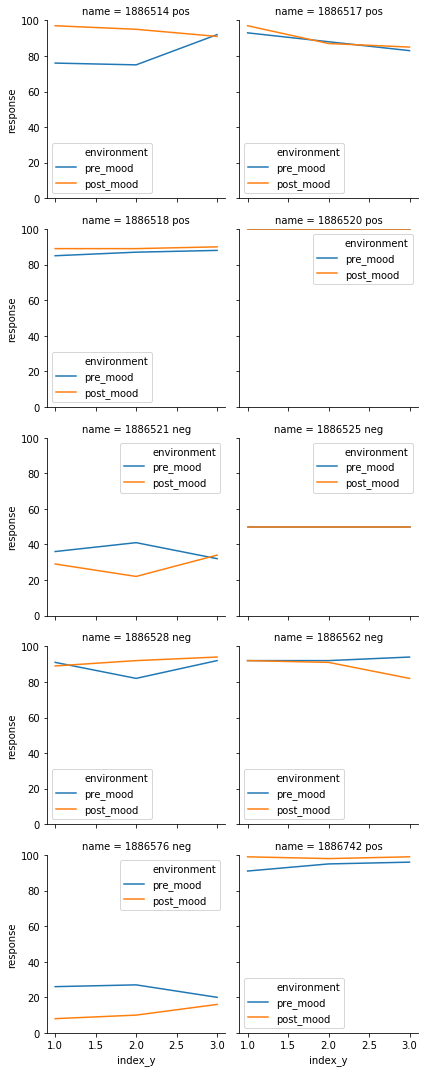

In [44]:
r = sns.FacetGrid(rating, col="name", col_wrap=2, height=3, ylim=(0, 100))
r.map(sns.lineplot, "index_y", "response", "environment")
for ax in r.axes.ravel():
    ax.legend()

plt.savefig("rating_by_subject.png", transparent=True, dpi=300)
# g = sns.FacetGrid(plot, col="id", col_wrap=4, height=2, ylim=(50, 300))
# g.map(sns.lineplot,'price_displayed','average_latency', 'environment', palette = "GnBu_d", legend = 'full',
#       err_style="bars")



In [45]:
# 1886525
# 1886520
# rating[rating.Subject == 1886520]

# Look at neg and pos seperately?

In [47]:
fish.head()

,Subject,UTC Timestamp,key pressed,price_displayed,environment,task,function id,builtin rt,end_time,start_time,response,round_instance,trial_label,environment_binary,latency,mood
5,1886514.000,1598309451438.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,70.425,1598309451324.000,1598309451253,nan,1.000,pre_mood 1.0,0,175.000,pos
6,1886514.000,1598309451563.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,30.795,1598309451459.000,1598309451428,nan,1.000,pre_mood 1.0,0,134.000,pos
7,1886514.000,1598309451688.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,16.975,1598309451580.000,1598309451562,nan,1.000,pre_mood 1.0,0,121.000,pos
8,1886514.000,1598309451830.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,32.335,1598309451715.000,1598309451683,nan,1.000,pre_mood 1.0,0,136.000,pos
9,1886514.000,1598309452025.000,40.000,0.400,pre_mood,fishing_pos,fishing_pos,88.255,1598309451908.000,1598309451819,nan,1.000,pre_mood 1.0,0,193.000,pos


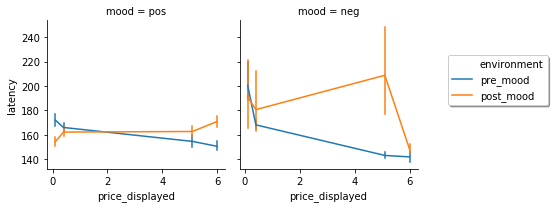

In [66]:
b = sns.FacetGrid(fish, col="mood", col_order=["pos", "neg"])
b = b.map(sns.lineplot, "price_displayed", "latency", "environment",
         err_style = "bars")
for ax in b.axes.ravel():
    ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True)
    
plt.savefig("average_latency_pos_neg.png", transparent = True, dpi = 300)
